# Aperture Photometry on Sky Background

The goal of this notebook is to perform aperture photometry on the sky background of the image, to find the true photometric error caused by it. SEXtractor doesn't allow us to manually set the apertures for photometry, so we'll use Photutils to set the pixel coordinates of our apertures and do the photometry. The Photutils info is in this link: https://photutils.readthedocs.io/en/stable/aperture.html

## Preliminar: FITS Data and simple plot

In [2]:
import photutils #photutils package

from astropy.wcs import WCS #extract wcs info from FITS images
from astropy.io import fits #import FITS images to the notebook
from astropy.visualization import ZScaleInterval #zscale algorithm for image visualization

import matplotlib.pyplot as plt #image plots
import numpy as np #numpy, always useful
from IPython.display import display #to display tables in a well-looked format
import pandas as pd
import math

In [3]:
image = fits.open('S2_u.fits') #open FITS file
data = image[0].data #extract image data
wcs = WCS(image[0].header) #extract wcs info

In [4]:
ZSCALE = ZScaleInterval(500) #zscale algorithm with 500 sample pixels
zscale = ZSCALE.get_limits(data) #get zscale limits

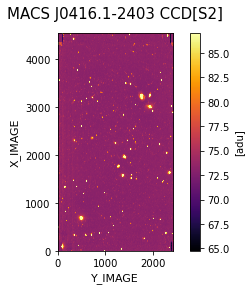

In [5]:
fig,ax = plt.subplots()#figsize=(40,40)) #image and colorbar subplots
im = ax.imshow(data,vmin=zscale[0],vmax=87,cmap='inferno',origin='lower') #data plot
ax.set_xlabel('Y_IMAGE',fontsize=11) #x label
ax.set_ylabel('X_IMAGE',fontsize=11) #y label
ax.set_title('MACS J0416.1-2403 CCD[S2]',pad=15.0,fontsize=15) #plot title
fig.colorbar(im,label='[adu]') #colorbar label
fig.savefig('CCD_S2.pdf') #save image in pdf format

## Photutils Apertures

In [6]:
from photutils.aperture import CircularAperture,ApertureStats

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.stats import sigma_clipped_stats
from astropy.table import QTable #to convert array into QTable format

from photutils.aperture import SkyCircularAperture
from photutils.aperture import aperture_photometry

We're going to perform the aperture photometry. This technique consists in calculate all the flux $F$ on a determined aperture, e.g, measure all the light of the pixels inside the aperture. This flux will have $[adu]$ units. In our case, we're going to use circular apertures with a radius equals to 5 pixels distributed throughout the sky background, approximately 100 apertures. Also, we'll calculate the associate error of the flux. This error is calculated as:

\begin{equation*}
    \Delta F_i = \sqrt{A_i\sigma_i^2+\frac{F_i}{g_i}}
\end{equation*}

where $i$ corresponds to an aperture, $A$ is the area of the aperture (number of pixels on the aperture), $\sigma$ is the standard deviation of the background, $F$ is the flux (number of counts on the aperture) and $g_i$ is the gain of the pixel. For each aperture, $g_i$ and $A_i$ are the same, so the formula is:

\begin{equation*}
    \Delta F_i = \sqrt{A\sigma_i^2+\frac{F_i}{g}}
\end{equation*}

$A$ is the number of pixels in the aperture, e.g, the area: $A=\pi r^2=\pi5^2\approx 78.539$. Now, we have to perform the aperture photometry once in order to get the aperture sum term (flux), and get the statistics of the photometry to get the $\sigma$ for each aperture.

In [7]:
positions = np.genfromtxt('S2_apertures.txt',usecols=(3,4)) #pixel coordinates in a .txt file, work done on ds9
apertures = CircularAperture(positions,r=5) #transform positions into circular apertures
phot_table = aperture_photometry(data,apertures,method='subpixel',subpixels=5) #performs the aperture photometry on the image data

for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g' #for consistent table output

print('Aperture Sum table')
display(phot_table[:10]) #plot aperture photmetry table, with center coordinates and aperture sum

#CALCULATE STATISTICS
aper_stats = ApertureStats(data,apertures) #calculate aperture's statistics
columns = ('id','mean','median','std','var') #columns to make a statistics table
stats_table = aper_stats.to_table(columns) #aggregate the values to a table

for col in stats_table.colnames:
    stats_table[col].info.format = '%.8g' #fix format

print('Statistics Table')
display(stats_table[:10]) #plot statistics table, with mean, median, std, variance and sum

#CALCULATE FLUX ERROR BY DEFINITION
area = np.pi*(5**2) #aperture's area: A = pi*r^2, r=5
std = stats_table['std'] #sigma of the background
flux = phot_table['aperture_sum'] #sum of the pixels in the aperture
gain = 4.0 #detector gain
error = np.sqrt(area*(std**2)+(flux/gain)) #error definition
phot_table.add_column(error,name='aperture_sum_error') #append error column to phot_table

for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g' #for consistent table output

print('Aperture sum and error table')
phot_table[:10] #plot aperture photmetry table, with center coordinates, aperture sum and associate error

Aperture Sum table


id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,460.01977,336.57396,5746.3356
2,612.73324,431.41706,5769.5601
3,790.36313,223.24448,5771.102
4,1323.6467,268.04391,5790.6643
5,1492.7702,413.72453,5784.2669
6,1696.4998,302.09187,5780.1394
7,1661.8937,458.37759,5743.1711
8,1860.5998,279.20717,5721.0228


Statistics Table


id,mean,median,std,var
int64,float64,float64,float64,float64
1,73.183377,73.134678,1.5908287,2.5307359
2,73.566788,73.644592,1.2992632,1.6880848
3,73.358429,73.45063,1.541089,2.3749552
4,73.66397,73.517567,1.3761888,1.8938956
5,73.644239,73.619858,1.3572229,1.8420539
6,73.300823,73.327995,1.3745166,1.889296
7,73.303308,73.174271,1.2167624,1.4805108
8,73.190214,73.187401,1.2885774,1.6604318
9,73.420674,73.453125,1.526287,2.3295521


Aperture sum and error table


id,xcenter,ycenter,aperture_sum,aperture_sum_error
,pix,pix,,
int64,float64,float64,float64,float64
1,460.01977,336.57396,5746.3356,40.439429
2,612.73324,431.41706,5769.5601,39.685916
3,790.36313,223.24448,5771.102,40.364638
4,1323.6467,268.04391,5790.6643,39.955128
5,1492.7702,413.72453,5784.2669,39.884098
6,1696.4998,302.09187,5780.1394,39.917663
7,1661.8937,458.37759,5743.1711,39.396343
8,1860.5998,279.20717,5721.0228,39.505262


In [8]:
#there is a code that 'transform' our apertures into regions to visualize them on ds9
from regions import Regions,PixCoord
from regions import CirclePixelRegion

open('S2_regions.reg','w').close() #create an empty file with .reg extension. If we recompile the code, the keyword 'w' delete all the previous dile content
reg_array = Regions.read('S2_regions.reg', format='ds9') #read the empty file as a region array
center = PixCoord(x=phot_table['xcenter'],y=phot_table['ycenter']) #transform the (x,y) coords from phot_table in pixel coordinates centers
for i in range(len(center)): #for each (x,y) center
    region = CirclePixelRegion(center=center[i],radius=10,) #create regions with (x,y) centers and radius=5
    reg_array.append(region) #append each region to the region array
reg_array.write('S2_regions.reg',overwrite=True) #append all the info of the region array on the .reg file

with open('S2_regions.reg','r') as f: #open in read mode the new .reg file
    ds9_param = f.readlines() #readlines
    ds9_param.insert(1,'global color=red dashlist=8 3 width=3 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\n')
    #insert ds9 regions parameters in the second line without delete the actual second line
with open('S2_regions.reg','w') as f: #open in write mode the new .reg file
    ds9_param = "".join(ds9_param) #append the ds9 regions parameters
    f.write(ds9_param) #write the changes

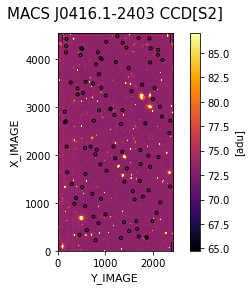

In [9]:
fig,ax = plt.subplots()#figsize=(40,40)) #image and colorbar subplots
im = ax.imshow(data,vmin=zscale[0],vmax=87,cmap='inferno',origin='lower') #data plot
reg_visual = Regions.read('S2_regions.reg', format='ds9') #regions file
for i in range(100): #1 to 100 regions
    r = reg_visual[i] #extract each region
    r.plot(ax=ax,edgecolor='k') #plot the region
ax.set_xlabel('Y_IMAGE',fontsize=11) #x label
ax.set_ylabel('X_IMAGE',fontsize=11) #y label
ax.set_title('MACS J0416.1-2403 CCD[S2]',pad=15.0,fontsize=15) #plot title
fig.colorbar(im,label='[adu]') #colorbar label
fig.savefig('CCD_S2.pdf') #save image in pdf format

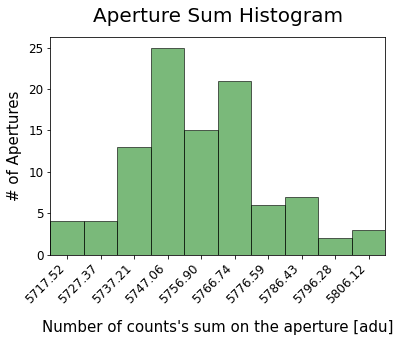

In [10]:
plt.hist(phot_table['aperture_sum'],bins=10,align='mid',facecolor='forestgreen',edgecolor='black',alpha=0.6) #histogram of aperture photometry
plt.ylabel('# of Apertures',labelpad=6,fontsize=15) #y label
plt.xlabel('Number of counts\'s sum on the aperture [adu]',labelpad=14,fontsize=15) #x label
plt.title('Aperture Sum Histogram',fontsize=20,pad=15) #histogram title
max_lim = max(phot_table['aperture_sum']) #max value of aperture sum table
min_lim = min(phot_table['aperture_sum']) #min value of aperture sum table
plt.xlim(min_lim,max_lim) #x axe lmits, in this case, min and max of aperture sum
diff = (max_lim-min_lim)/10 # width of the bin
plt.xticks(np.linspace(min_lim+diff/2,max_lim-diff/2,10),rotation=45,ha='right',fontsize=12) #x label ticks, center of hte bins
plt.yticks(fontsize=12) #y label ticks parameters
plt.show() #show the plot

## Magnitudes and Background Fluctuations

The magnitude is calculated in this way:
\begin{equation*}
    m=ZP-2.5\log_{10}{\left(\frac{F}{EXPTIME}\right)}
\end{equation*}

where $ZP$ is the photometric "zero point" (meanwhile, we consider $ZP=0$), $F$ is the total flux in the aperture in units of $[adu]$ and $EXPTIME$ is the exposure time in units of $[seconds]$.

In [11]:
flux = phot_table['aperture_sum'] #100 aperture sums
exptime = 700 #700 seconds
mag = -2.5*np.log10(flux/exptime) #magnitud definition with zero_point=0.0

mag_table = QTable([mag],names=('MAG',)) #create a QTable with the data
mag_table.add_column(np.arange(1,len(mag_table)+1),name='id',index=0) #appending an index
display(mag_table[:10]) #table data

id,MAG
int64,float64
1,-2.2857324
2,-2.2901117
3,-2.2904018
4,-2.2940759
5,-2.2928757
6,-2.2921007
7,-2.2851343
8,-2.2809391
9,-2.2878879


We have 100 instrumental magnitudes measured on the sky background. Now, we want the fluctuation of this magnitudes, so we're going to calculate the standard deviation of the magnitudes. The formula is:

\begin{equation*}
    \sigma = \sqrt{\frac{1}{N}\displaystyle\sum_{i}^{N}(m_i-\bar{m})^2}
\end{equation*}

where $N=100$ is the total of apertures, $m_i$ is the magnitude on the aperture $i$ and $\bar{m}$ is the mean magnitude of the sample.

In [12]:
mag_sigma = np.std(mag) #calculate standard deviation of the 100 background magnitudes
print('Standard Deviation = '+str(mag_sigma))
print('Variance           = '+str(mag_sigma**2))

Standard Deviation = 0.003779298232700301
Variance           = 1.4283095131691618e-05


The standard deviation $\sigma$ in this case (the [S2] CCD) is:

\begin{equation*}
    \sigma = 0.003779298 \Longrightarrow \sigma^2 = 0.00001428309 = 1.4238309\times 10^{-5}
\end{equation*}

Now, the quantity $\sigma^2$ is unique per CCD (since it considers fluctuations caused by the effects of that CCD) needs to be added in quadrature-sum to the magnitude error calculated by SEXtractor while performs the photometry. Considering $\delta m$ as the magnitude error of a source, now the total magnitude error is defined by:

\begin{equation*}
    \Delta m_j^2=\delta m_j^2+\sigma^2 \Longrightarrow \Delta m_j=\sqrt{\delta m_j^2+\sigma^2}
\end{equation*}

where $j$ is the source in a CCD. Therefore, we have to calculate a $\sigma^2$ fluctuation for every CCD (and filter too) caused by pupil ghosts, fringing, combine residuals, etc. Then, the actual magniutde error formula is:

\begin{equation*}
    \Delta m_{jk}^2=\delta m_{jk}^2+\sigma_j^2 \Longrightarrow \Delta m_{jk}=\sqrt{\delta m_{jk}^2+\sigma_j^2}
\end{equation*}

where now $j$ is the CCD and $k$ is the source in that CCD.

### Magnitude errors

In the next lines we're going to apply the magnitude error's definition used by SEXtractor, that is:

\begin{equation*}
    \Delta m_i = 1.0857\cdot\frac{\sqrt{A_i\sigma_i^{2}+\frac{F_i}{g}}}{F_i}
\end{equation*}

where $i$ is the aperture, $A$ is the aperture's area in pixels, $\sigma$ is the standard deviation of the background in units of $[adu]$, $F$ is the flux used before and $g$ is the gain of the detector. For simplicity's sake, we'll use a standard value for the gain:

\begin{equation*}
    GAIN=4.0 [e^{-}/s]
\end{equation*}

Using our aperture sums and the sigma of the apertures given by the stats\_table:

In [13]:
F = phot_table['aperture_sum'] #aperture sum data, 100 apertures
A = np.pi*(5**2) #aperture area, A=pi*r^2, where r=5 pixels
g = 4.0 #gain value
term_1 = np.sqrt(A*((stats_table['std'])**2)+(F/g)) #square root term
term_2 = 1.0857/F #constant divided by flux
delta_mag = term_1*term_2 #delta mag calculus

mag_table.add_column(delta_mag,name='MAG_ERROR',index=2) #append mag_error column

for col in mag_table.colnames:
    mag_table[col].info.format = '%.8g' #round values

mag_table[:10] #table data

id,MAG,MAG_ERROR
int64,float64,float64
1,-2.2857324,0.0076405367
2,-2.2901117,0.0074679868
3,-2.2904018,0.0075936776
4,-2.2940759,0.0074912447
5,-2.2928757,0.0074861977
6,-2.2921007,0.007497848
7,-2.2851343,0.0074475597
8,-2.2809391,0.007497062
9,-2.2878879,0.0075951403


An easier way to do this calculation is to use this formula:
\begin{equation*}
    \Delta m_i = 1.0857\cdot\frac{\Delta F_i}{F_i}
\end{equation*}

where the term $\Delta F_i$ was calculated in the top of this notebook.

In [15]:
delta_mag_2 = 1.0857*phot_table['aperture_sum_error']/phot_table['aperture_sum']
delta_mag_2

0.0076405367
0.0074679868
0.0075936776
0.0074912447
0.0074861977
0.007497848
0.0074475597
0.007497062
0.0075951403
0.0074508194
0.007469359
